In [41]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from AlphaDataCenterCooling_Gym.alphaDataCenterCoolingEnv import AlphaDataCenterCoolingEnv

# PART 1

## 1.1 Initialize Simulation Parameters

In [42]:
# Define the time step for the simulation
step=300
# Initialize the AlphaDataCenter environment with specific configurations
env = AlphaDataCenterCoolingEnv(
    '../schema.json',  # Path to the environment configuration file. This file defines the initial settings and parameters for the simulation.
    simulation_start_time=0, # Simulation start time in seconds. Optiional, if provided, will override the default value read from the schema.json file.
    seconds_per_step=step,# Sets the interval of each step in seconds. Optiional, if provided, will override the default value read from the schema.json file
    simulation_end_time=300*2000, # Simulation end time in seconds. Optiional, if provided, will override the default value read from the schema.json file.
    active_observations=['P_CDWPs_sum','P_CHWPs_sum'] # Specifies which observations to actively monitor and record during the simulation.Optiional, if provided, will override the default value read from the schema.json file
)

## 1.2 Reset the Environment

In [43]:
# Reset the environment to start a new episode
state = env.reset()

In [44]:
print(state)

[26268.707 22873.688]


## 1.3 Load control inputs from a CSV file, run the Simulation and collect Data

In [45]:
# Load control inputs from a CSV file
df = pd.read_csv('RealWorld_Actions_Observations.csv')
df2 = df[
    ['U_CT1', 'U_CT2', 'U_CT3', 'U_CT4', 'U_CT5', 'U_CT6', 'Ffan_CT1_01', 'Ffan_CT1_02', 'Ffan_CT2_01', 'Ffan_CT2_02',
     'Ffan_CT3_01', 'Ffan_CT3_02', 'Ffan_CT4_01', 'Ffan_CT4_02', 'Ffan_CT5_01', 'Ffan_CT5_02', 'Ffan_CT6_01',
     'Ffan_CT6_02', 'CDWP01_rpm', 'CDWP02_rpm', 'CDWP03_rpm', 'CDWP04_rpm', 'CDWP05_rpm', 'CDWP06_rpm', 'CHWP01_rpm',
     'CHWP02_rpm', 'CHWP03_rpm', 'CHWP04_rpm', 'CHWP05_rpm', 'CHWP06_rpm', 'CHI01', 'CHI02', 'CHI03', 'CHI04', 'CHI05',
     'CHI06', 'CHI01_CW1', 'CHI01_CW2', 'CHI01_CW3', 'CHI01_CW4', 'CHI02_CW1', 'CHI02_CW2', 'CHI02_CW3', 'CHI02_CW4',
     'CHI03_CW1', 'CHI03_CW2', 'CHI03_CW3', 'CHI03_CW4', 'CHI04_CW1', 'CHI04_CW2', 'CHI04_CW3', 'CHI04_CW4',
     'CHI05_CW1', 'CHI05_CW2', 'CHI05_CW3', 'CHI05_CW4', 'CHI06_CW1', 'CHI06_CW2', 'CHI06_CW3', 'CHI06_CW4',
     'CHI01_CHW1', 'CHI01_CHW2', 'CHI01_CHW3', 'CHI01_CHW4', 'CHI02_CHW1', 'CHI02_CHW2', 'CHI02_CHW3', 'CHI02_CHW4',
     'CHI03_CHW1', 'CHI03_CHW2', 'CHI03_CHW3', 'CHI03_CHW4', 'CHI04_CHW1', 'CHI04_CHW2', 'CHI04_CHW3', 'CHI04_CHW4',
     'CHI05_CHW1', 'CHI05_CHW2', 'CHI05_CHW3', 'CHI05_CHW4', 'CHI06_CHW1', 'CHI06_CHW2', 'CHI06_CHW3', 'CHI06_CHW4',
     'CDWP01_ONOFF', 'CDWP02_ONOFF', 'CDWP03_ONOFF', 'CDWP04_ONOFF', 'CDWP05_ONOFF', 'CDWP06_ONOFF', 'CHWP01_ONOFF',
     'CHWP02_ONOFF', 'CHWP03_ONOFF', 'CHWP04_ONOFF', 'CHWP05_ONOFF', 'CHWP06_ONOFF', 'CWP_speedInput', 'Tchws_set_CHI',
     'Tchws_set_HEX', 'CWP_activatedNumber']]

P_CDWPs_sum=[]
P_CHWPs_sum=[]
times=[]
done=False
t=0 # Initialize time counter
idx=0
while not done:
    u=df2.iloc[idx].tolist()
    obs,reward, done, info =env.step(u)
    P_CDWPs_sum.append(obs[0])
    P_CHWPs_sum.append(obs[1])
    times.append(t)
    idx+=1
    t+=step
# Save the simulation results to a CSV file
df=pd.DataFrame({'time':times,'P_CDWPs_sum':P_CDWPs_sum,'P_CHWPs_sum':P_CHWPs_sum})
df.to_csv('Pumps_P_Pyfmi_mlp_gym.csv')

## 1.4 Data Loading and Simulation Results Overview

In [46]:
# Load the ground truth measurements
df_truth = pd.read_csv('RealWorld_Actions_Observations.csv', usecols=['P_CDWPs_sum', 'P_CHWPs_sum'])

# Load simulation results from MATLAB Simulink
df_simulink = pd.read_csv('Pumps_P_Simulink.csv')

# Load simulation results using PyFMI library for FMU interactions, accessed via a REST API.
# The 'Head_required' is is computed using an MLP (Multi-Layer Perceptron) neural network
df_pyfmi_mlp = pd.read_csv('Pumps_P_Pyfmi_mlp_restapi.csv')

# Load simulation results using PyFMI library for FMU interactions, accessed via a Gym environment.
# The 'Head_required' is is computed using an MLP (Multi-Layer Perceptron) neural network
df_pyfmi_mlp_gym = pd.read_csv('Pumps_P_Pyfmi_mlp_gym.csv')

### a) Comparative analysis of the sum of condenser water pump power \[KW\](P_CDWPs_sum)

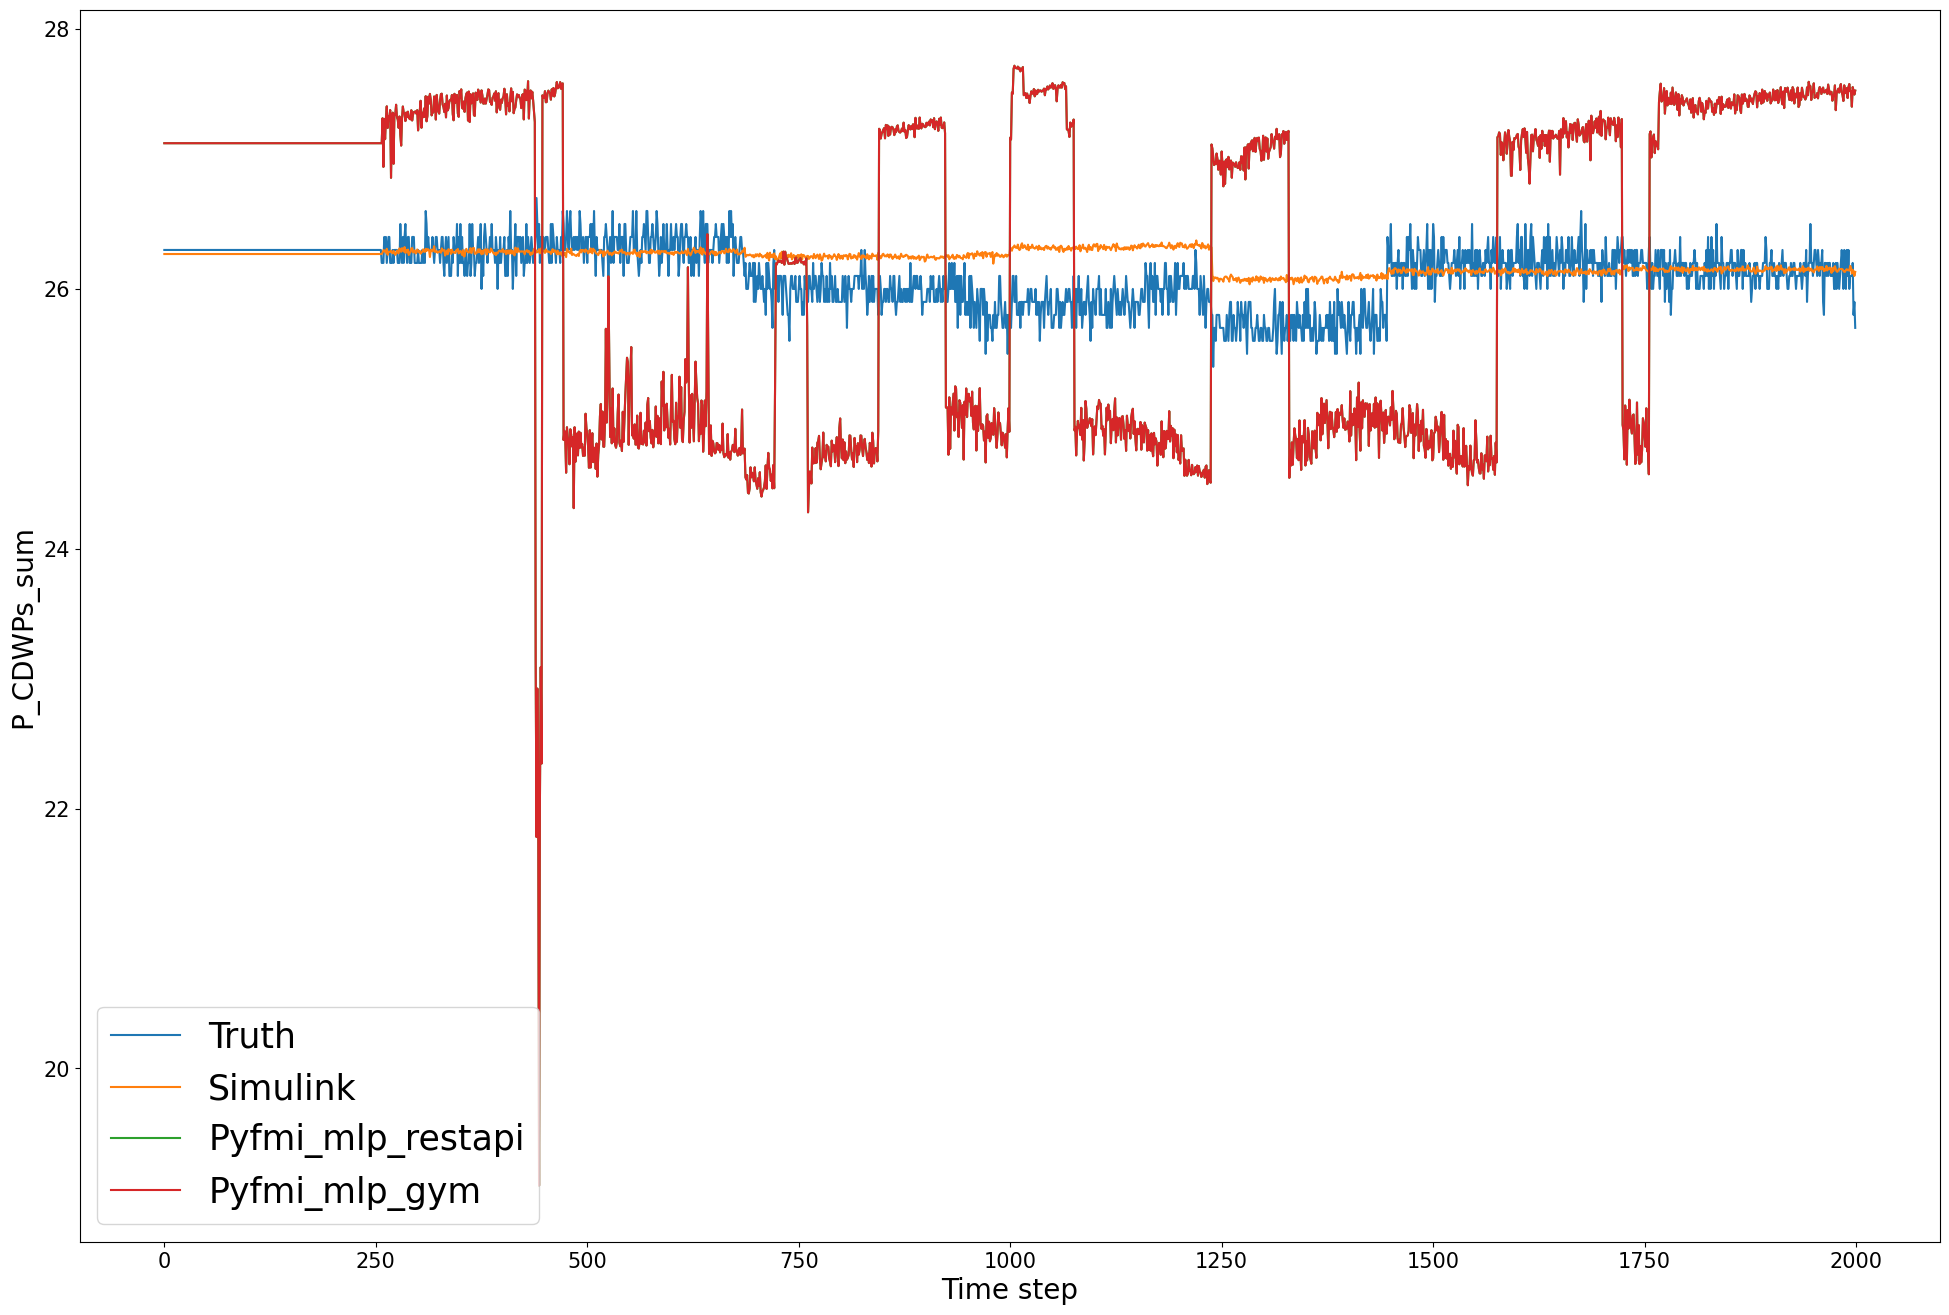

In [53]:
plt.figure(figsize=(24, 16))
plt.plot(range(0, 2000), df_truth['P_CDWPs_sum'].iloc[1:2001], label='Truth')
plt.plot(range(0, 2000), df_simulink['Pcdwp_sum'].iloc[1:2001], label='Simulink')

plt.plot(range(0, 2000), df_pyfmi_mlp['P_CDWPs_sum'].iloc[0:2000] / 1000, label='Pyfmi_mlp_restapi')
plt.plot(range(0, 2000), df_pyfmi_mlp_gym['P_CDWPs_sum'].iloc[0:2000] / 1000, label='Pyfmi_mlp_gym')

plt.legend(fontsize=25)
# plt.title('Simulink vs. Pyfmi P_CDWPs_sum Comparative Analysis',fontsize=30)
plt.xlabel('Time step', fontsize=20)
plt.ylabel('P_CDWPs_sum', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### b) Comparative analysis of the sum of  chilled water pump power \[KW\] (P_CDWPs_sum)

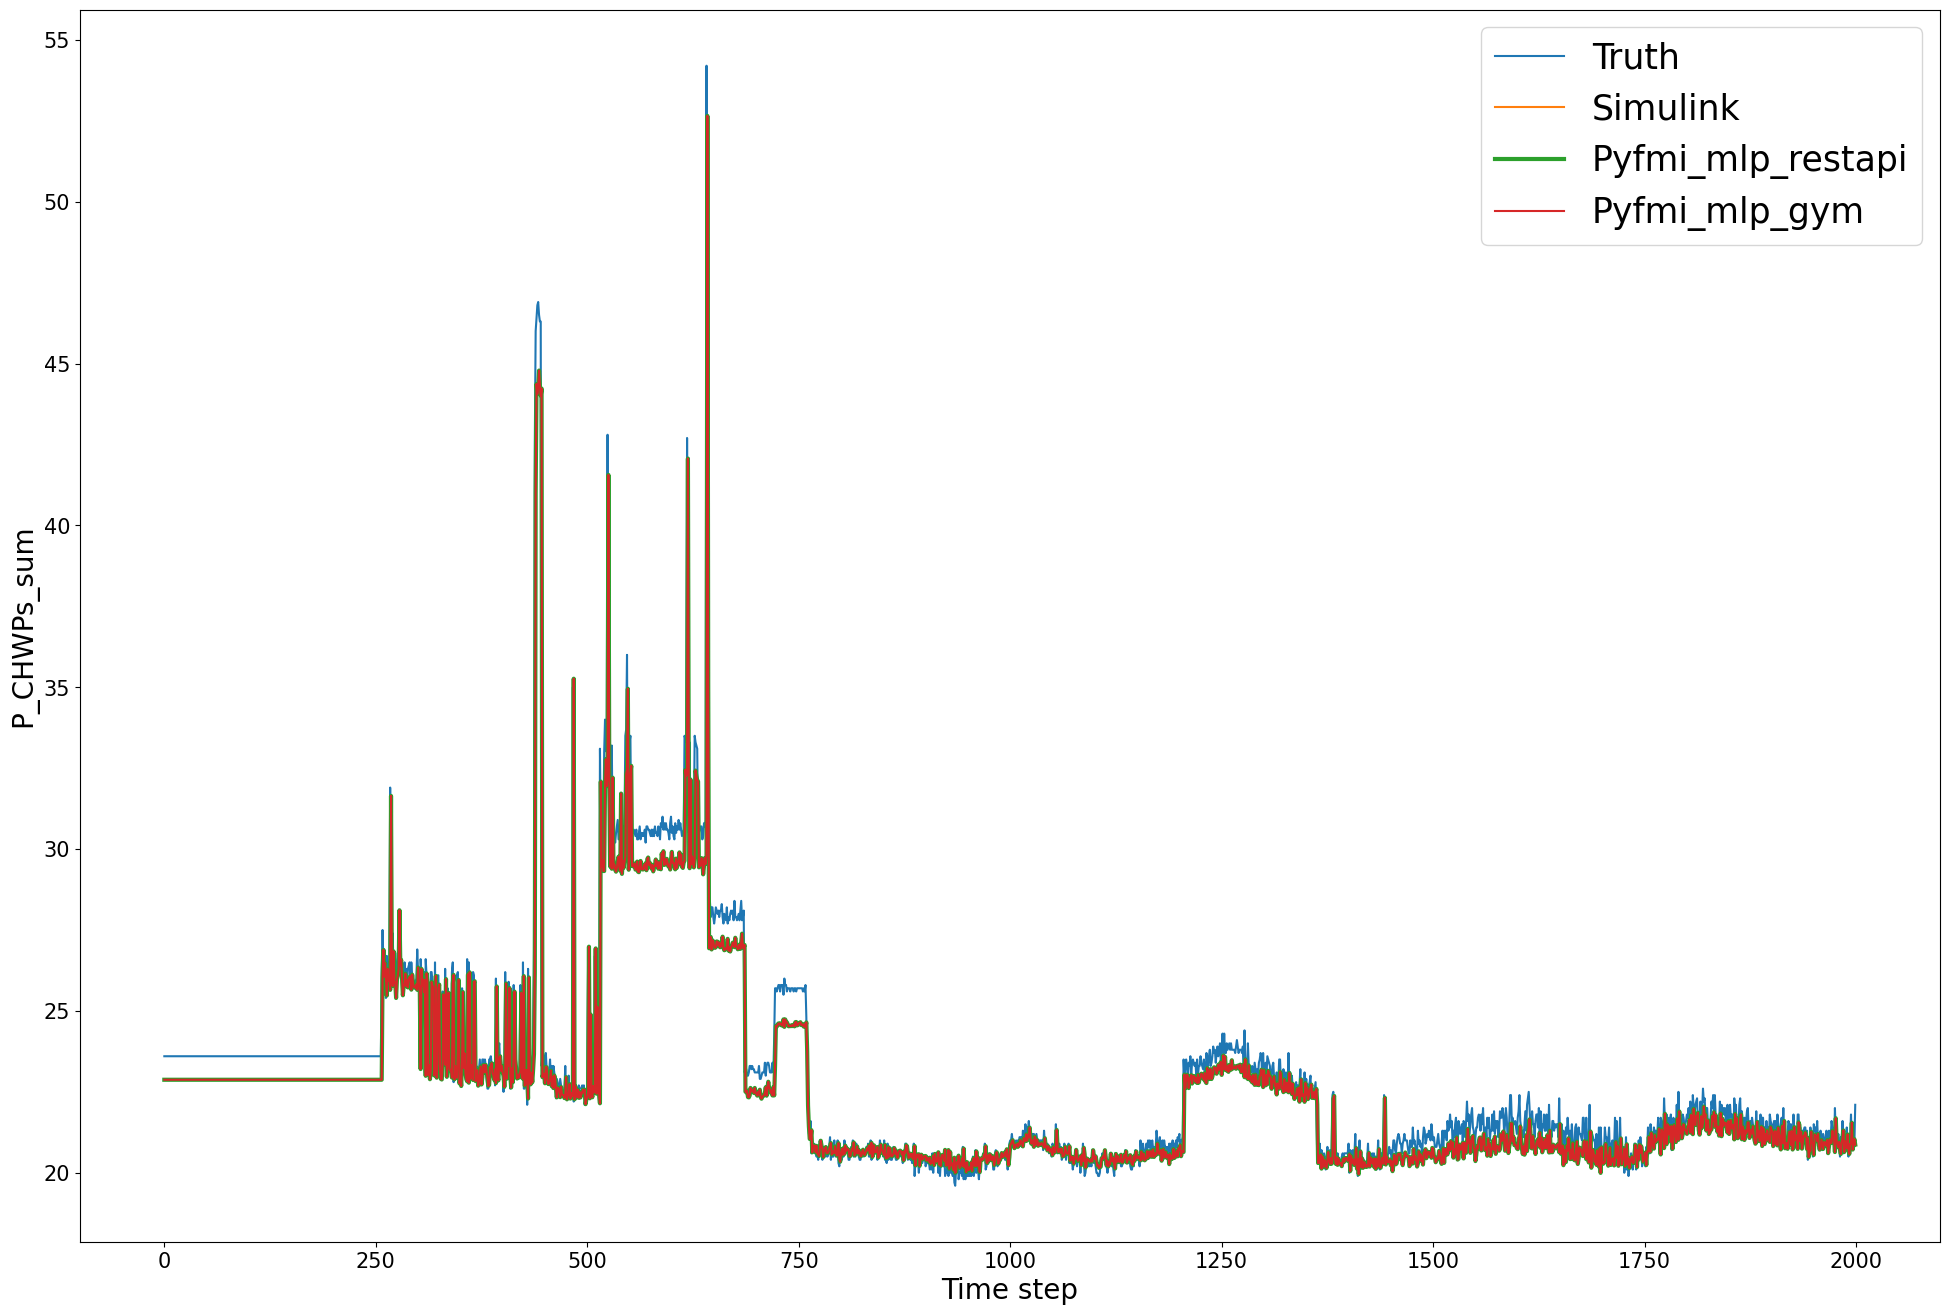

In [12]:
plt.figure(figsize=(24, 16))
plt.plot(range(0, 2000), df_truth['P_CHWPs_sum'].iloc[1:2001], label='Truth')
plt.plot(range(0, 2000), df_simulink['Pchwp_sum'].iloc[1:2001], label='Simulink')

plt.plot(range(0, 2000), df_pyfmi_mlp['P_CHWPs_sum'].iloc[0:2000] / 1000, label='Pyfmi_mlp_restapi',lw=3)
plt.plot(range(0, 2000), df_pyfmi_mlp_gym['P_CHWPs_sum'].iloc[0:2000] / 1000, label='Pyfmi_mlp_gym')

plt.legend(fontsize=25)
# plt.title('Simulink vs. Pyfmi P_CDWPs_sum Comparative Analysis',fontsize=30)
plt.xlabel('Time step', fontsize=20)
plt.ylabel('P_CHWPs_sum', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# PART 2:  Validation of Simulation Starting from Specified Time (In Multiples of 5 Minutes)

In [77]:
step = 300
env = AlphaDataCenterCoolingEnv('../schema.json', simulation_start_time=300*1000, seconds_per_step=step,
                         active_observations=['P_CDWPs_sum', 'P_CHWPs_sum'])
state = env.reset()

df = pd.read_csv('FMUinputs.csv')
df2 = df[
    ['U_CT1', 'U_CT2', 'U_CT3', 'U_CT4', 'U_CT5', 'U_CT6', 'Ffan_CT1_01', 'Ffan_CT1_02', 'Ffan_CT2_01', 'Ffan_CT2_02',
     'Ffan_CT3_01', 'Ffan_CT3_02', 'Ffan_CT4_01', 'Ffan_CT4_02', 'Ffan_CT5_01', 'Ffan_CT5_02', 'Ffan_CT6_01',
     'Ffan_CT6_02', 'CDWP01_rpm', 'CDWP02_rpm', 'CDWP03_rpm', 'CDWP04_rpm', 'CDWP05_rpm', 'CDWP06_rpm', 'CHWP01_rpm',
     'CHWP02_rpm', 'CHWP03_rpm', 'CHWP04_rpm', 'CHWP05_rpm', 'CHWP06_rpm', 'CHI01', 'CHI02', 'CHI03', 'CHI04', 'CHI05',
     'CHI06', 'CHI01_CW1', 'CHI01_CW2', 'CHI01_CW3', 'CHI01_CW4', 'CHI02_CW1', 'CHI02_CW2', 'CHI02_CW3', 'CHI02_CW4',
     'CHI03_CW1', 'CHI03_CW2', 'CHI03_CW3', 'CHI03_CW4', 'CHI04_CW1', 'CHI04_CW2', 'CHI04_CW3', 'CHI04_CW4',
     'CHI05_CW1', 'CHI05_CW2', 'CHI05_CW3', 'CHI05_CW4', 'CHI06_CW1', 'CHI06_CW2', 'CHI06_CW3', 'CHI06_CW4',
     'CHI01_CHW1', 'CHI01_CHW2', 'CHI01_CHW3', 'CHI01_CHW4', 'CHI02_CHW1', 'CHI02_CHW2', 'CHI02_CHW3', 'CHI02_CHW4',
     'CHI03_CHW1', 'CHI03_CHW2', 'CHI03_CHW3', 'CHI03_CHW4', 'CHI04_CHW1', 'CHI04_CHW2', 'CHI04_CHW3', 'CHI04_CHW4',
     'CHI05_CHW1', 'CHI05_CHW2', 'CHI05_CHW3', 'CHI05_CHW4', 'CHI06_CHW1', 'CHI06_CHW2', 'CHI06_CHW3', 'CHI06_CHW4',
     'CDWP01_ONOFF', 'CDWP02_ONOFF', 'CDWP03_ONOFF', 'CDWP04_ONOFF', 'CDWP05_ONOFF', 'CDWP06_ONOFF', 'CHWP01_ONOFF',
     'CHWP02_ONOFF', 'CHWP03_ONOFF', 'CHWP04_ONOFF', 'CHWP05_ONOFF', 'CHWP06_ONOFF', 'CWP_speedInput', 'Tchws_set_CHI',
     'Tchws_set_HEX', 'CWP_activatedNumber']]

P_CDWPs_sum = []
P_CHWPs_sum = []
times = []
t = 0

total_steps = 1000
for i in tqdm(range(total_steps)):
    u = df2.iloc[1000+i].tolist()
    obs, _, _, _ = env.step(u)
    P_CDWPs_sum.append(obs[0])
    P_CHWPs_sum.append(obs[1])
    times.append(t)
    t += step
df = pd.DataFrame({'time': times, 'P_CDWPs_sum': P_CDWPs_sum, 'P_CHWPs_sum': P_CHWPs_sum})
df.to_csv('Pumps_P_Pyfmi_mlp_gym_start_from_3e5.csv')

100%|██████████| 1000/1000 [01:46<00:00,  9.42it/s]


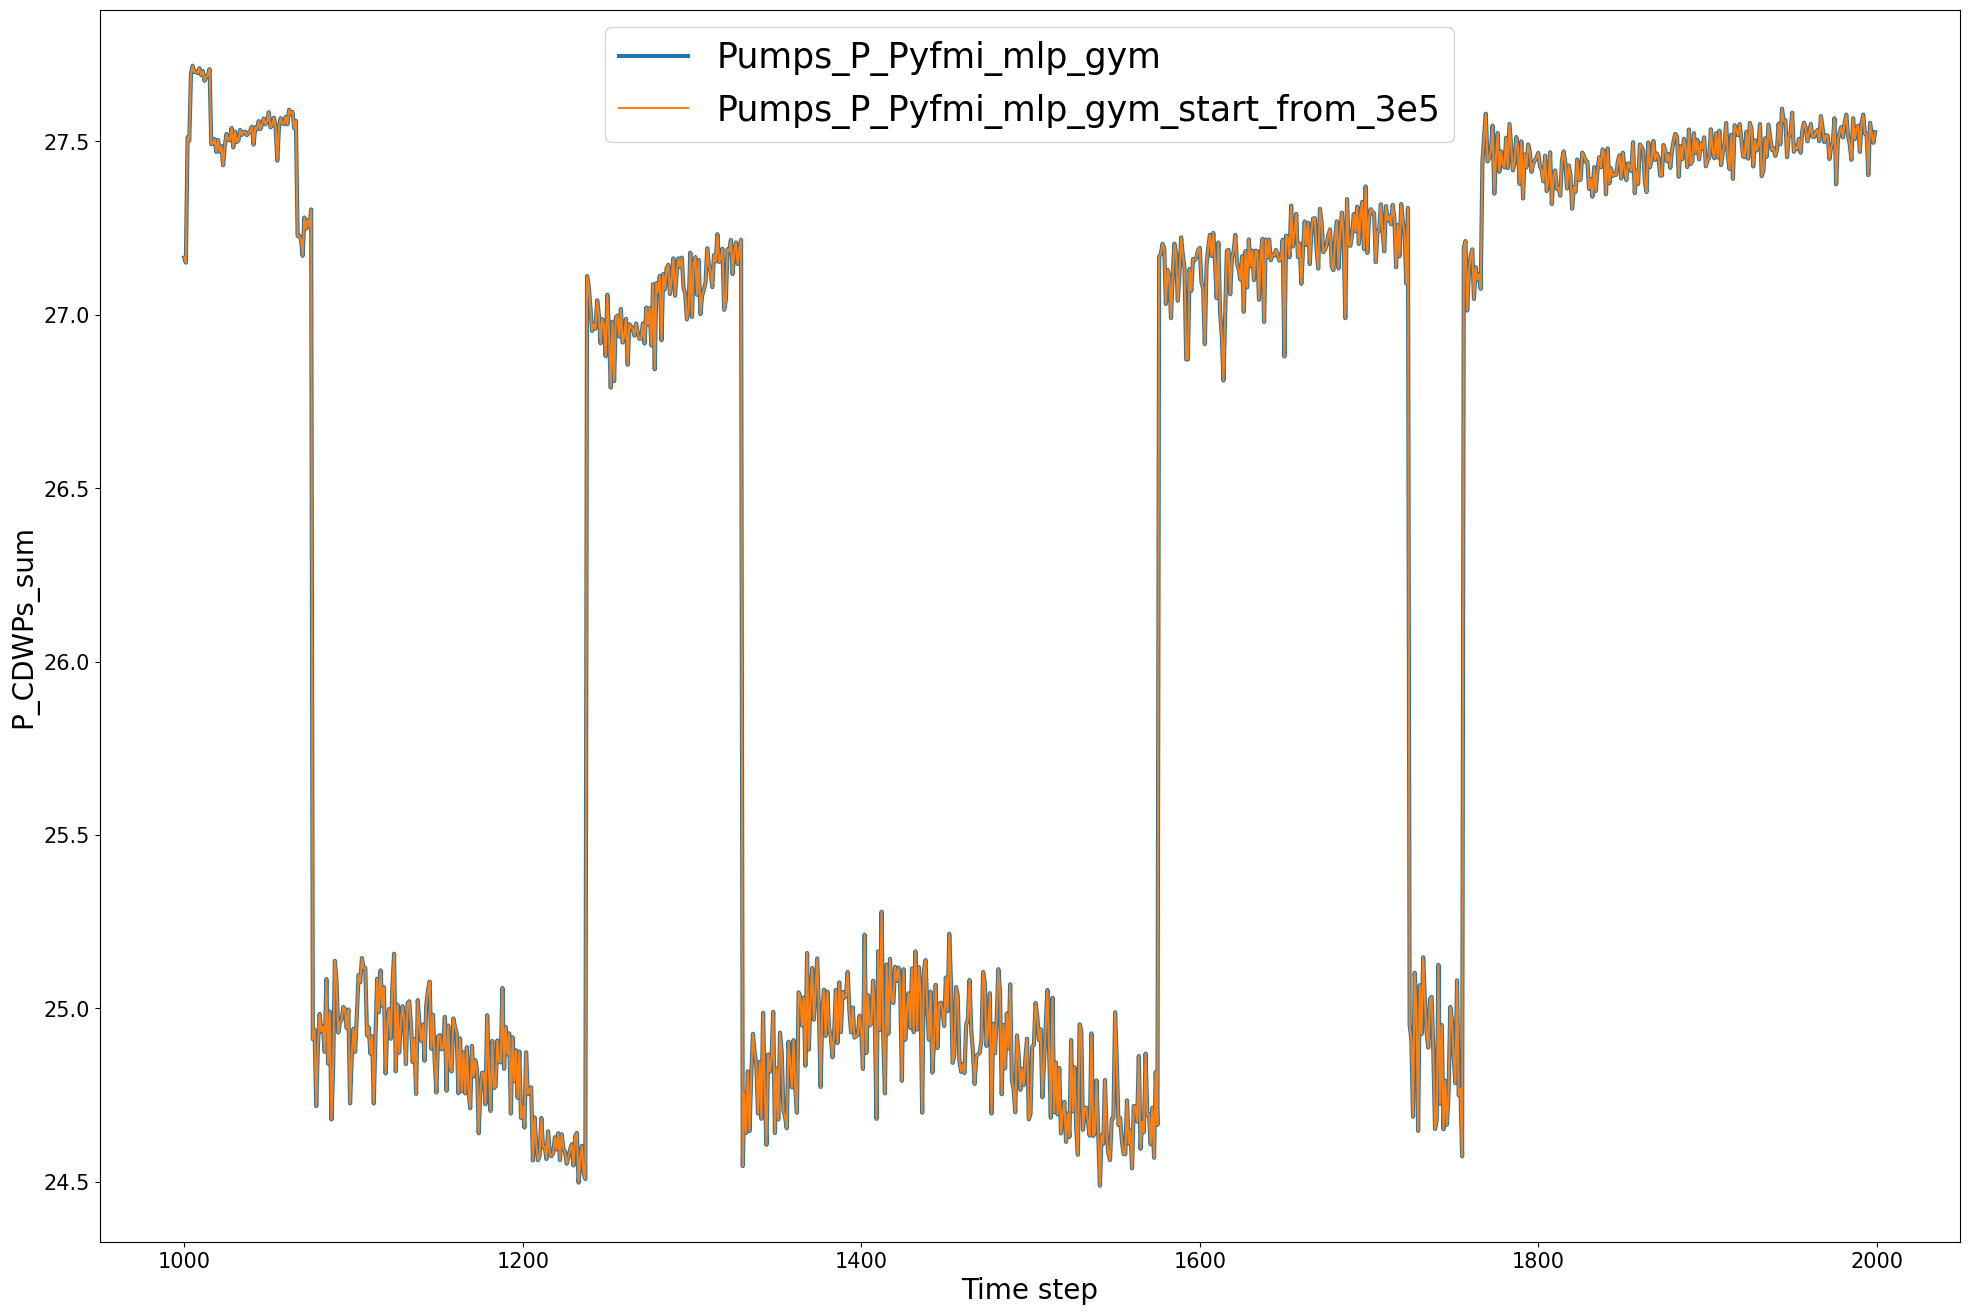

In [79]:
df_pyfmi_mlp_gym = pd.read_csv('Pumps_P_Pyfmi_mlp_gym.csv')
df_pyfmi_mlp_gym2 = pd.read_csv('Pumps_P_Pyfmi_mlp_gym_start_from_3e5.csv')
plt.figure(figsize=(24, 16))

plt.plot(range(1000, 2000), df_pyfmi_mlp_gym['P_CDWPs_sum'].iloc[1000:2000] / 1000, label='Pumps_P_Pyfmi_mlp_gym', lw=3)
plt.plot(range(1000, 2000), df_pyfmi_mlp_gym2['P_CDWPs_sum'].iloc[0:1000] / 1000, label='Pumps_P_Pyfmi_mlp_gym_start_from_3e5')
plt.legend(fontsize=25)
# plt.title('Simulink vs. Pyfmi P_CDWPs_sum Comparative Analysis',fontsize=30)
plt.xlabel('Time step', fontsize=20)
plt.ylabel('P_CDWPs_sum', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# PART 3: Testing Simulation with Different Time Intervals

## 3.1  seconds_per_step=60 minutes

In [80]:
step = 300*12
env = AlphaDataCenterCoolingEnv('../schema.json', simulation_start_time=0, seconds_per_step=step,
                         active_observations=['P_CDWPs_sum', 'P_CHWPs_sum'])
state = env.reset()

df = pd.read_csv('FMUinputs.csv')
df2 = df[
    ['U_CT1', 'U_CT2', 'U_CT3', 'U_CT4', 'U_CT5', 'U_CT6', 'Ffan_CT1_01', 'Ffan_CT1_02', 'Ffan_CT2_01', 'Ffan_CT2_02',
     'Ffan_CT3_01', 'Ffan_CT3_02', 'Ffan_CT4_01', 'Ffan_CT4_02', 'Ffan_CT5_01', 'Ffan_CT5_02', 'Ffan_CT6_01',
     'Ffan_CT6_02', 'CDWP01_rpm', 'CDWP02_rpm', 'CDWP03_rpm', 'CDWP04_rpm', 'CDWP05_rpm', 'CDWP06_rpm', 'CHWP01_rpm',
     'CHWP02_rpm', 'CHWP03_rpm', 'CHWP04_rpm', 'CHWP05_rpm', 'CHWP06_rpm', 'CHI01', 'CHI02', 'CHI03', 'CHI04', 'CHI05',
     'CHI06', 'CHI01_CW1', 'CHI01_CW2', 'CHI01_CW3', 'CHI01_CW4', 'CHI02_CW1', 'CHI02_CW2', 'CHI02_CW3', 'CHI02_CW4',
     'CHI03_CW1', 'CHI03_CW2', 'CHI03_CW3', 'CHI03_CW4', 'CHI04_CW1', 'CHI04_CW2', 'CHI04_CW3', 'CHI04_CW4',
     'CHI05_CW1', 'CHI05_CW2', 'CHI05_CW3', 'CHI05_CW4', 'CHI06_CW1', 'CHI06_CW2', 'CHI06_CW3', 'CHI06_CW4',
     'CHI01_CHW1', 'CHI01_CHW2', 'CHI01_CHW3', 'CHI01_CHW4', 'CHI02_CHW1', 'CHI02_CHW2', 'CHI02_CHW3', 'CHI02_CHW4',
     'CHI03_CHW1', 'CHI03_CHW2', 'CHI03_CHW3', 'CHI03_CHW4', 'CHI04_CHW1', 'CHI04_CHW2', 'CHI04_CHW3', 'CHI04_CHW4',
     'CHI05_CHW1', 'CHI05_CHW2', 'CHI05_CHW3', 'CHI05_CHW4', 'CHI06_CHW1', 'CHI06_CHW2', 'CHI06_CHW3', 'CHI06_CHW4',
     'CDWP01_ONOFF', 'CDWP02_ONOFF', 'CDWP03_ONOFF', 'CDWP04_ONOFF', 'CDWP05_ONOFF', 'CDWP06_ONOFF', 'CHWP01_ONOFF',
     'CHWP02_ONOFF', 'CHWP03_ONOFF', 'CHWP04_ONOFF', 'CHWP05_ONOFF', 'CHWP06_ONOFF', 'CWP_speedInput', 'Tchws_set_CHI',
     'Tchws_set_HEX', 'CWP_activatedNumber']]

P_CDWPs_sum = []
P_CHWPs_sum = []
times = []
t = 0

total_steps = 100
for i in tqdm(range(total_steps)):
    u = df2.iloc[12*i].tolist()
    obs, _, _, _ = env.step(u)
    P_CDWPs_sum.append(obs[0])
    P_CHWPs_sum.append(obs[1])
    times.append(t)
    t += step
df = pd.DataFrame({'time': times, 'P_CDWPs_sum': P_CDWPs_sum, 'P_CHWPs_sum': P_CHWPs_sum})
df.to_csv('Pumps_P_Pyfmi_mlp_gym_step=60min.csv')

100%|██████████| 100/100 [01:41<00:00,  1.01s/it]


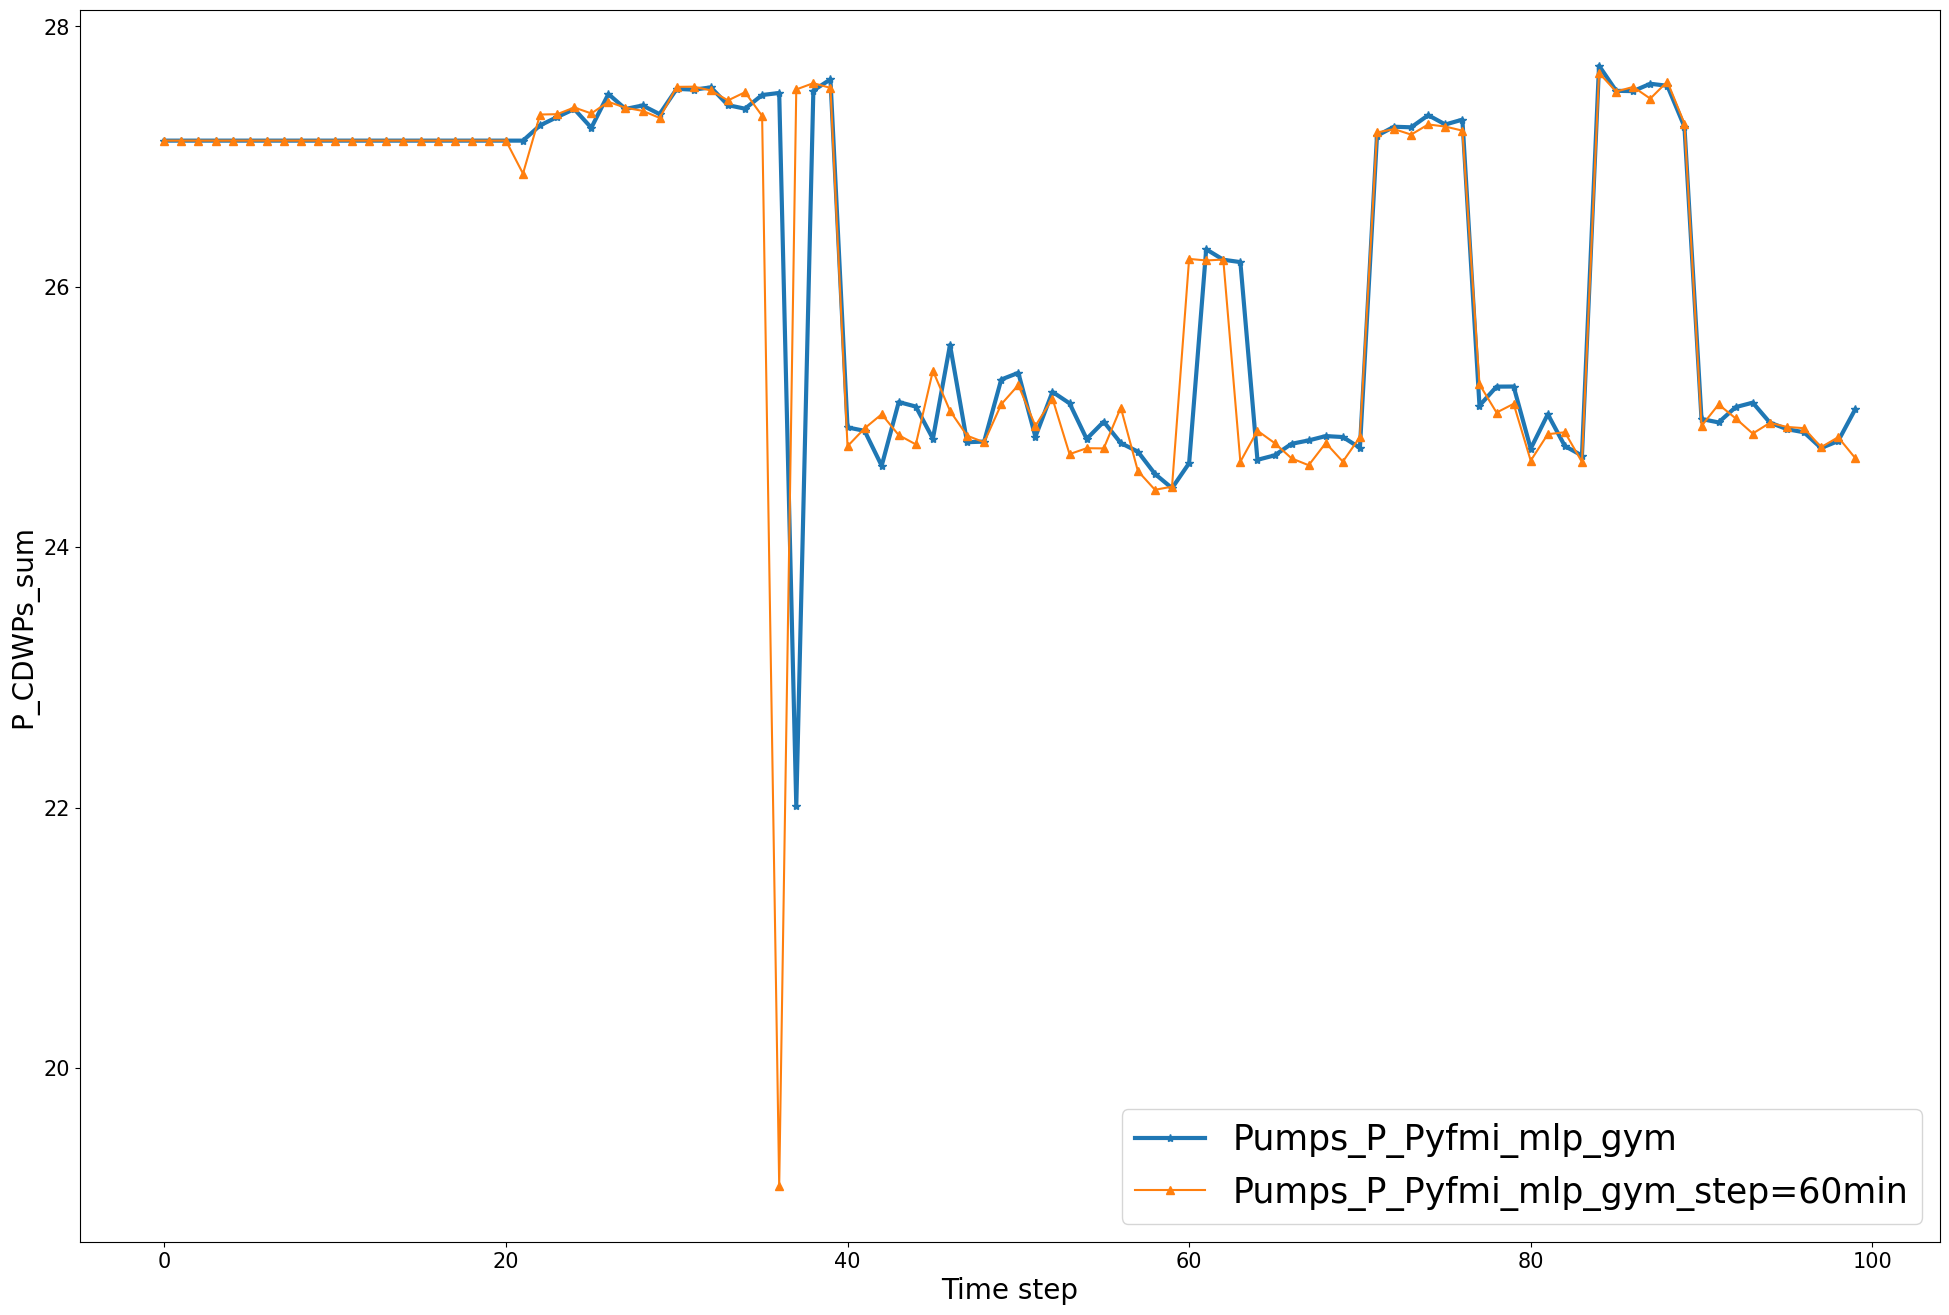

In [90]:
df_pyfmi_mlp_gym = pd.read_csv('Pumps_P_Pyfmi_mlp_gym.csv')

subset = df_pyfmi_mlp_gym['P_CDWPs_sum']
filtered_indices = subset.reset_index().index % 12 == 0
filtered_rows = subset[filtered_indices]
Pumps_P_Pyfmi_mlp_gym_60min_step = pd.read_csv('Pumps_P_Pyfmi_mlp_gym_step=60min.csv')
plt.figure(figsize=(24, 16))

plt.plot(range(0, 100), filtered_rows[0:100] / 1000,'*-', label='Pumps_P_Pyfmi_mlp_gym',  lw=3)
plt.plot(range(0, 100), Pumps_P_Pyfmi_mlp_gym_60min_step['P_CDWPs_sum'].iloc[0:100] / 1000,'^-', label='Pumps_P_Pyfmi_mlp_gym_step=60min')
plt.legend(fontsize=25)
# plt.title('Simulink vs. Pyfmi P_CDWPs_sum Comparative Analysis',fontsize=30)
plt.xlabel('Time step', fontsize=20)
plt.ylabel('P_CDWPs_sum', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## 3.2  seconds_per_step=30 minutes

In [85]:
step = 300*6
env = AlphaDataCenterCoolingEnv('../schema.json', simulation_start_time=0, seconds_per_step=step,
                         active_observations=['P_CDWPs_sum', 'P_CHWPs_sum'])
state = env.reset()

df = pd.read_csv('FMUinputs.csv')
df2 = df[
    ['U_CT1', 'U_CT2', 'U_CT3', 'U_CT4', 'U_CT5', 'U_CT6', 'Ffan_CT1_01', 'Ffan_CT1_02', 'Ffan_CT2_01', 'Ffan_CT2_02',
     'Ffan_CT3_01', 'Ffan_CT3_02', 'Ffan_CT4_01', 'Ffan_CT4_02', 'Ffan_CT5_01', 'Ffan_CT5_02', 'Ffan_CT6_01',
     'Ffan_CT6_02', 'CDWP01_rpm', 'CDWP02_rpm', 'CDWP03_rpm', 'CDWP04_rpm', 'CDWP05_rpm', 'CDWP06_rpm', 'CHWP01_rpm',
     'CHWP02_rpm', 'CHWP03_rpm', 'CHWP04_rpm', 'CHWP05_rpm', 'CHWP06_rpm', 'CHI01', 'CHI02', 'CHI03', 'CHI04', 'CHI05',
     'CHI06', 'CHI01_CW1', 'CHI01_CW2', 'CHI01_CW3', 'CHI01_CW4', 'CHI02_CW1', 'CHI02_CW2', 'CHI02_CW3', 'CHI02_CW4',
     'CHI03_CW1', 'CHI03_CW2', 'CHI03_CW3', 'CHI03_CW4', 'CHI04_CW1', 'CHI04_CW2', 'CHI04_CW3', 'CHI04_CW4',
     'CHI05_CW1', 'CHI05_CW2', 'CHI05_CW3', 'CHI05_CW4', 'CHI06_CW1', 'CHI06_CW2', 'CHI06_CW3', 'CHI06_CW4',
     'CHI01_CHW1', 'CHI01_CHW2', 'CHI01_CHW3', 'CHI01_CHW4', 'CHI02_CHW1', 'CHI02_CHW2', 'CHI02_CHW3', 'CHI02_CHW4',
     'CHI03_CHW1', 'CHI03_CHW2', 'CHI03_CHW3', 'CHI03_CHW4', 'CHI04_CHW1', 'CHI04_CHW2', 'CHI04_CHW3', 'CHI04_CHW4',
     'CHI05_CHW1', 'CHI05_CHW2', 'CHI05_CHW3', 'CHI05_CHW4', 'CHI06_CHW1', 'CHI06_CHW2', 'CHI06_CHW3', 'CHI06_CHW4',
     'CDWP01_ONOFF', 'CDWP02_ONOFF', 'CDWP03_ONOFF', 'CDWP04_ONOFF', 'CDWP05_ONOFF', 'CDWP06_ONOFF', 'CHWP01_ONOFF',
     'CHWP02_ONOFF', 'CHWP03_ONOFF', 'CHWP04_ONOFF', 'CHWP05_ONOFF', 'CHWP06_ONOFF', 'CWP_speedInput', 'Tchws_set_CHI',
     'Tchws_set_HEX', 'CWP_activatedNumber']]

P_CDWPs_sum = []
P_CHWPs_sum = []
times = []
t = 0

total_steps = 200
for i in tqdm(range(total_steps)):
    u = df2.iloc[6*i].tolist()
    obs, _, _, _ = env.step(u)
    P_CDWPs_sum.append(obs[0])
    P_CHWPs_sum.append(obs[1])
    times.append(t)
    t += step
df = pd.DataFrame({'time': times, 'P_CDWPs_sum': P_CDWPs_sum, 'P_CHWPs_sum': P_CHWPs_sum})
df.to_csv('Pumps_P_Pyfmi_mlp_gym_step=30min.csv')

100%|██████████| 200/200 [01:51<00:00,  1.80it/s]


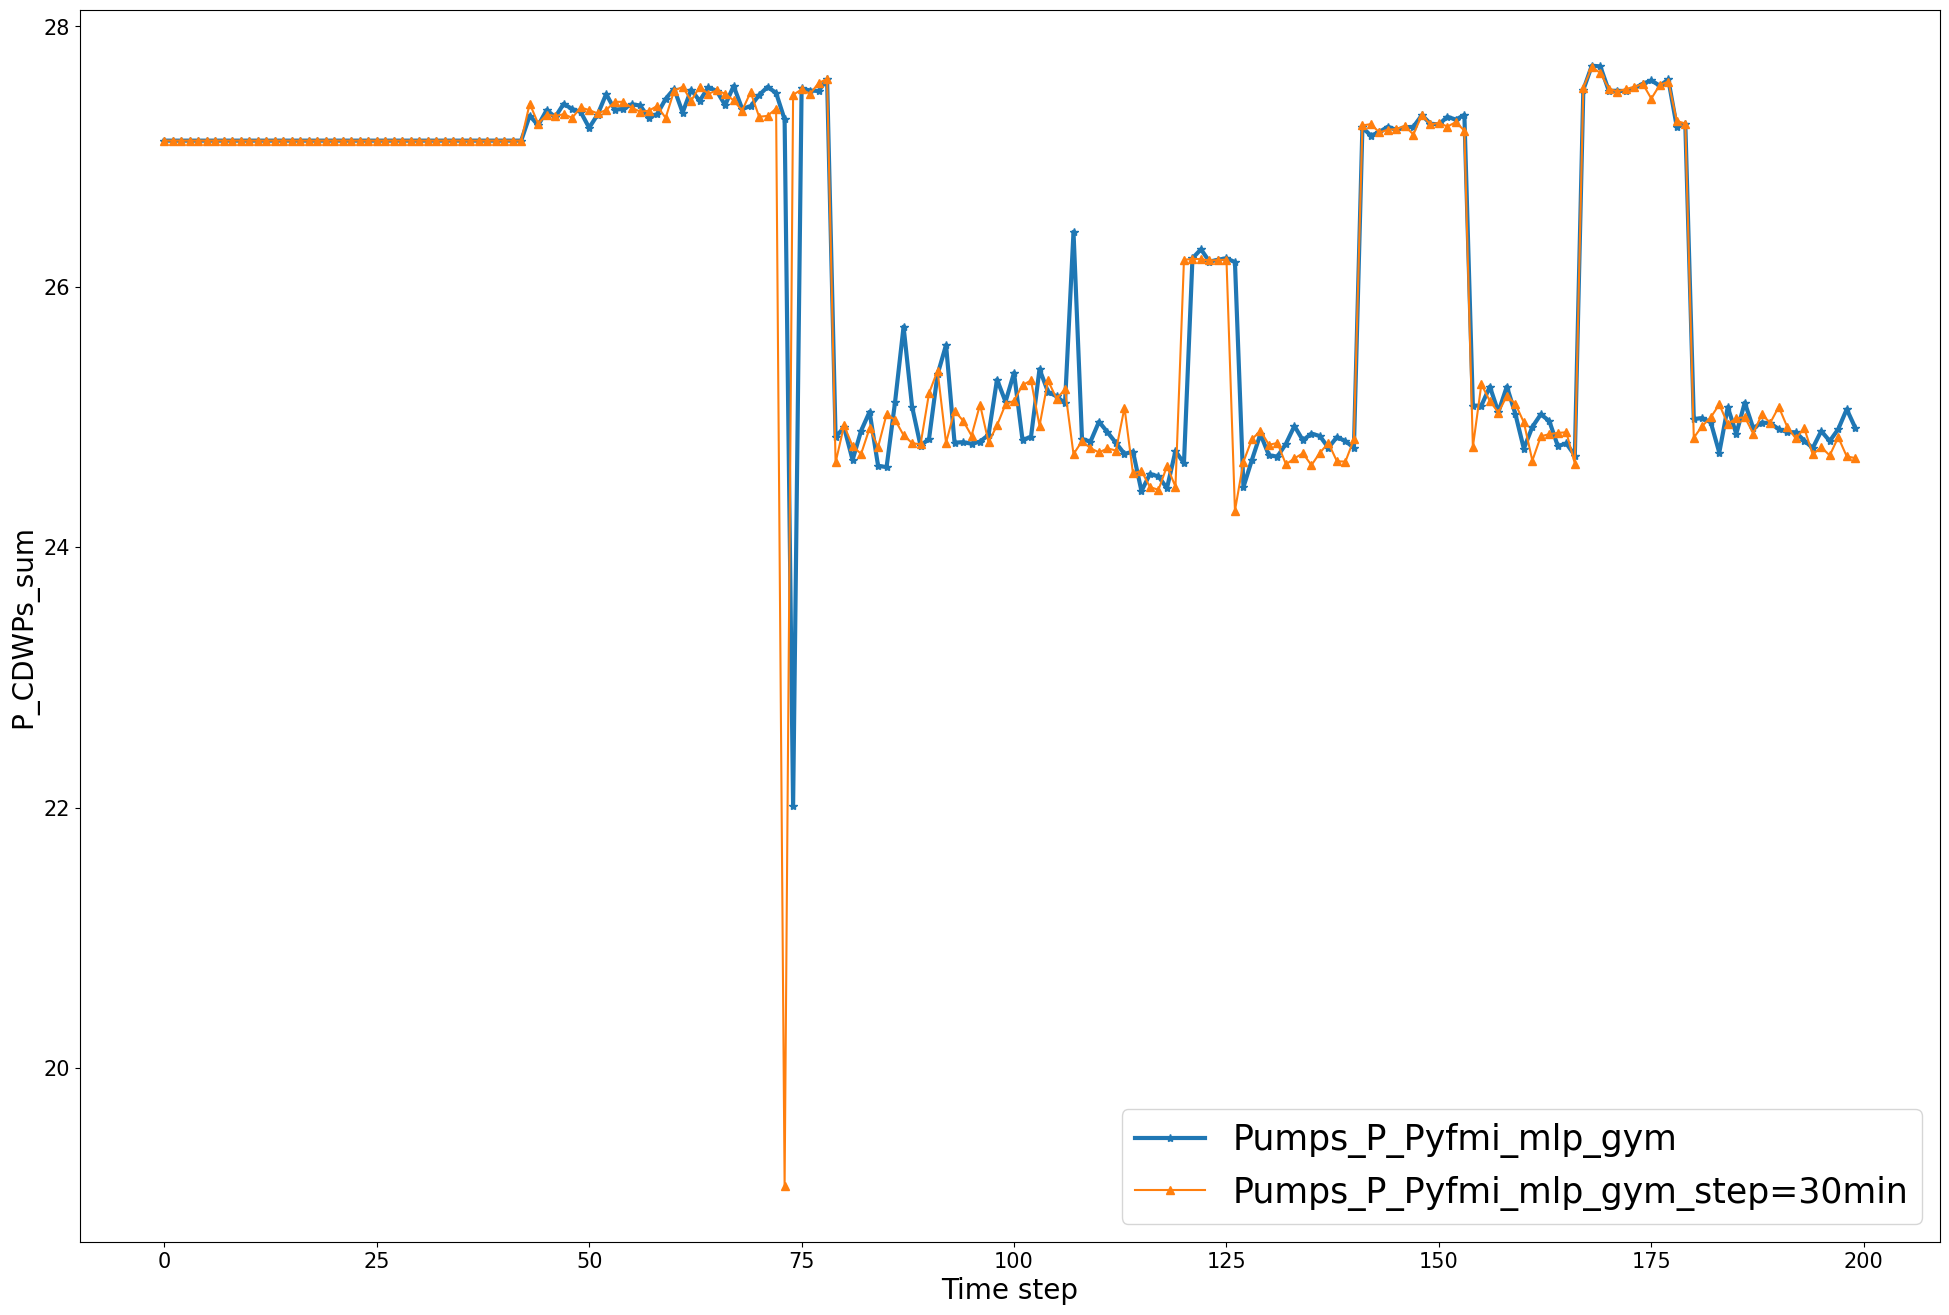

In [86]:
df_pyfmi_mlp_gym = pd.read_csv('Pumps_P_Pyfmi_mlp_gym.csv')

subset = df_pyfmi_mlp_gym['P_CDWPs_sum']
filtered_indices = subset.reset_index().index % 6 == 0
filtered_rows = subset[filtered_indices]
Pumps_P_Pyfmi_mlp_gym_30min_step = pd.read_csv('Pumps_P_Pyfmi_mlp_gym_step=30min.csv')
plt.figure(figsize=(24, 16))

plt.plot(range(0, 200), filtered_rows[0:200] / 1000,'*-', label='Pumps_P_Pyfmi_mlp_gym',  lw=3)
plt.plot(range(0, 200), Pumps_P_Pyfmi_mlp_gym_30min_step['P_CDWPs_sum'].iloc[0:200] / 1000,'^-', label='Pumps_P_Pyfmi_mlp_gym_step=30min')
plt.legend(fontsize=25)
# plt.title('Simulink vs. Pyfmi P_CDWPs_sum Comparative Analysis',fontsize=30)
plt.xlabel('Time step', fontsize=20)
plt.ylabel('P_CDWPs_sum', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## 3.3  seconds_per_step=10 minutes

In [87]:
step = 300*2
env = AlphaDataCenterCoolingEnv('../schema.json', simulation_start_time=0, seconds_per_step=step,
                         active_observations=['P_CDWPs_sum', 'P_CHWPs_sum'])
state = env.reset()

df = pd.read_csv('FMUinputs.csv')
df2 = df[
    ['U_CT1', 'U_CT2', 'U_CT3', 'U_CT4', 'U_CT5', 'U_CT6', 'Ffan_CT1_01', 'Ffan_CT1_02', 'Ffan_CT2_01', 'Ffan_CT2_02',
     'Ffan_CT3_01', 'Ffan_CT3_02', 'Ffan_CT4_01', 'Ffan_CT4_02', 'Ffan_CT5_01', 'Ffan_CT5_02', 'Ffan_CT6_01',
     'Ffan_CT6_02', 'CDWP01_rpm', 'CDWP02_rpm', 'CDWP03_rpm', 'CDWP04_rpm', 'CDWP05_rpm', 'CDWP06_rpm', 'CHWP01_rpm',
     'CHWP02_rpm', 'CHWP03_rpm', 'CHWP04_rpm', 'CHWP05_rpm', 'CHWP06_rpm', 'CHI01', 'CHI02', 'CHI03', 'CHI04', 'CHI05',
     'CHI06', 'CHI01_CW1', 'CHI01_CW2', 'CHI01_CW3', 'CHI01_CW4', 'CHI02_CW1', 'CHI02_CW2', 'CHI02_CW3', 'CHI02_CW4',
     'CHI03_CW1', 'CHI03_CW2', 'CHI03_CW3', 'CHI03_CW4', 'CHI04_CW1', 'CHI04_CW2', 'CHI04_CW3', 'CHI04_CW4',
     'CHI05_CW1', 'CHI05_CW2', 'CHI05_CW3', 'CHI05_CW4', 'CHI06_CW1', 'CHI06_CW2', 'CHI06_CW3', 'CHI06_CW4',
     'CHI01_CHW1', 'CHI01_CHW2', 'CHI01_CHW3', 'CHI01_CHW4', 'CHI02_CHW1', 'CHI02_CHW2', 'CHI02_CHW3', 'CHI02_CHW4',
     'CHI03_CHW1', 'CHI03_CHW2', 'CHI03_CHW3', 'CHI03_CHW4', 'CHI04_CHW1', 'CHI04_CHW2', 'CHI04_CHW3', 'CHI04_CHW4',
     'CHI05_CHW1', 'CHI05_CHW2', 'CHI05_CHW3', 'CHI05_CHW4', 'CHI06_CHW1', 'CHI06_CHW2', 'CHI06_CHW3', 'CHI06_CHW4',
     'CDWP01_ONOFF', 'CDWP02_ONOFF', 'CDWP03_ONOFF', 'CDWP04_ONOFF', 'CDWP05_ONOFF', 'CDWP06_ONOFF', 'CHWP01_ONOFF',
     'CHWP02_ONOFF', 'CHWP03_ONOFF', 'CHWP04_ONOFF', 'CHWP05_ONOFF', 'CHWP06_ONOFF', 'CWP_speedInput', 'Tchws_set_CHI',
     'Tchws_set_HEX', 'CWP_activatedNumber']]

P_CDWPs_sum = []
P_CHWPs_sum = []
times = []
t = 0

total_steps = 600
for i in tqdm(range(total_steps)):
    u = df2.iloc[2*i].tolist()
    obs, _, _, _ = env.step(u)
    P_CDWPs_sum.append(obs[0])
    P_CHWPs_sum.append(obs[1])
    times.append(t)
    t += step
df = pd.DataFrame({'time': times, 'P_CDWPs_sum': P_CDWPs_sum, 'P_CHWPs_sum': P_CHWPs_sum})
df.to_csv('Pumps_P_Pyfmi_mlp_gym_step=10min.csv')

100%|██████████| 600/600 [01:57<00:00,  5.10it/s]


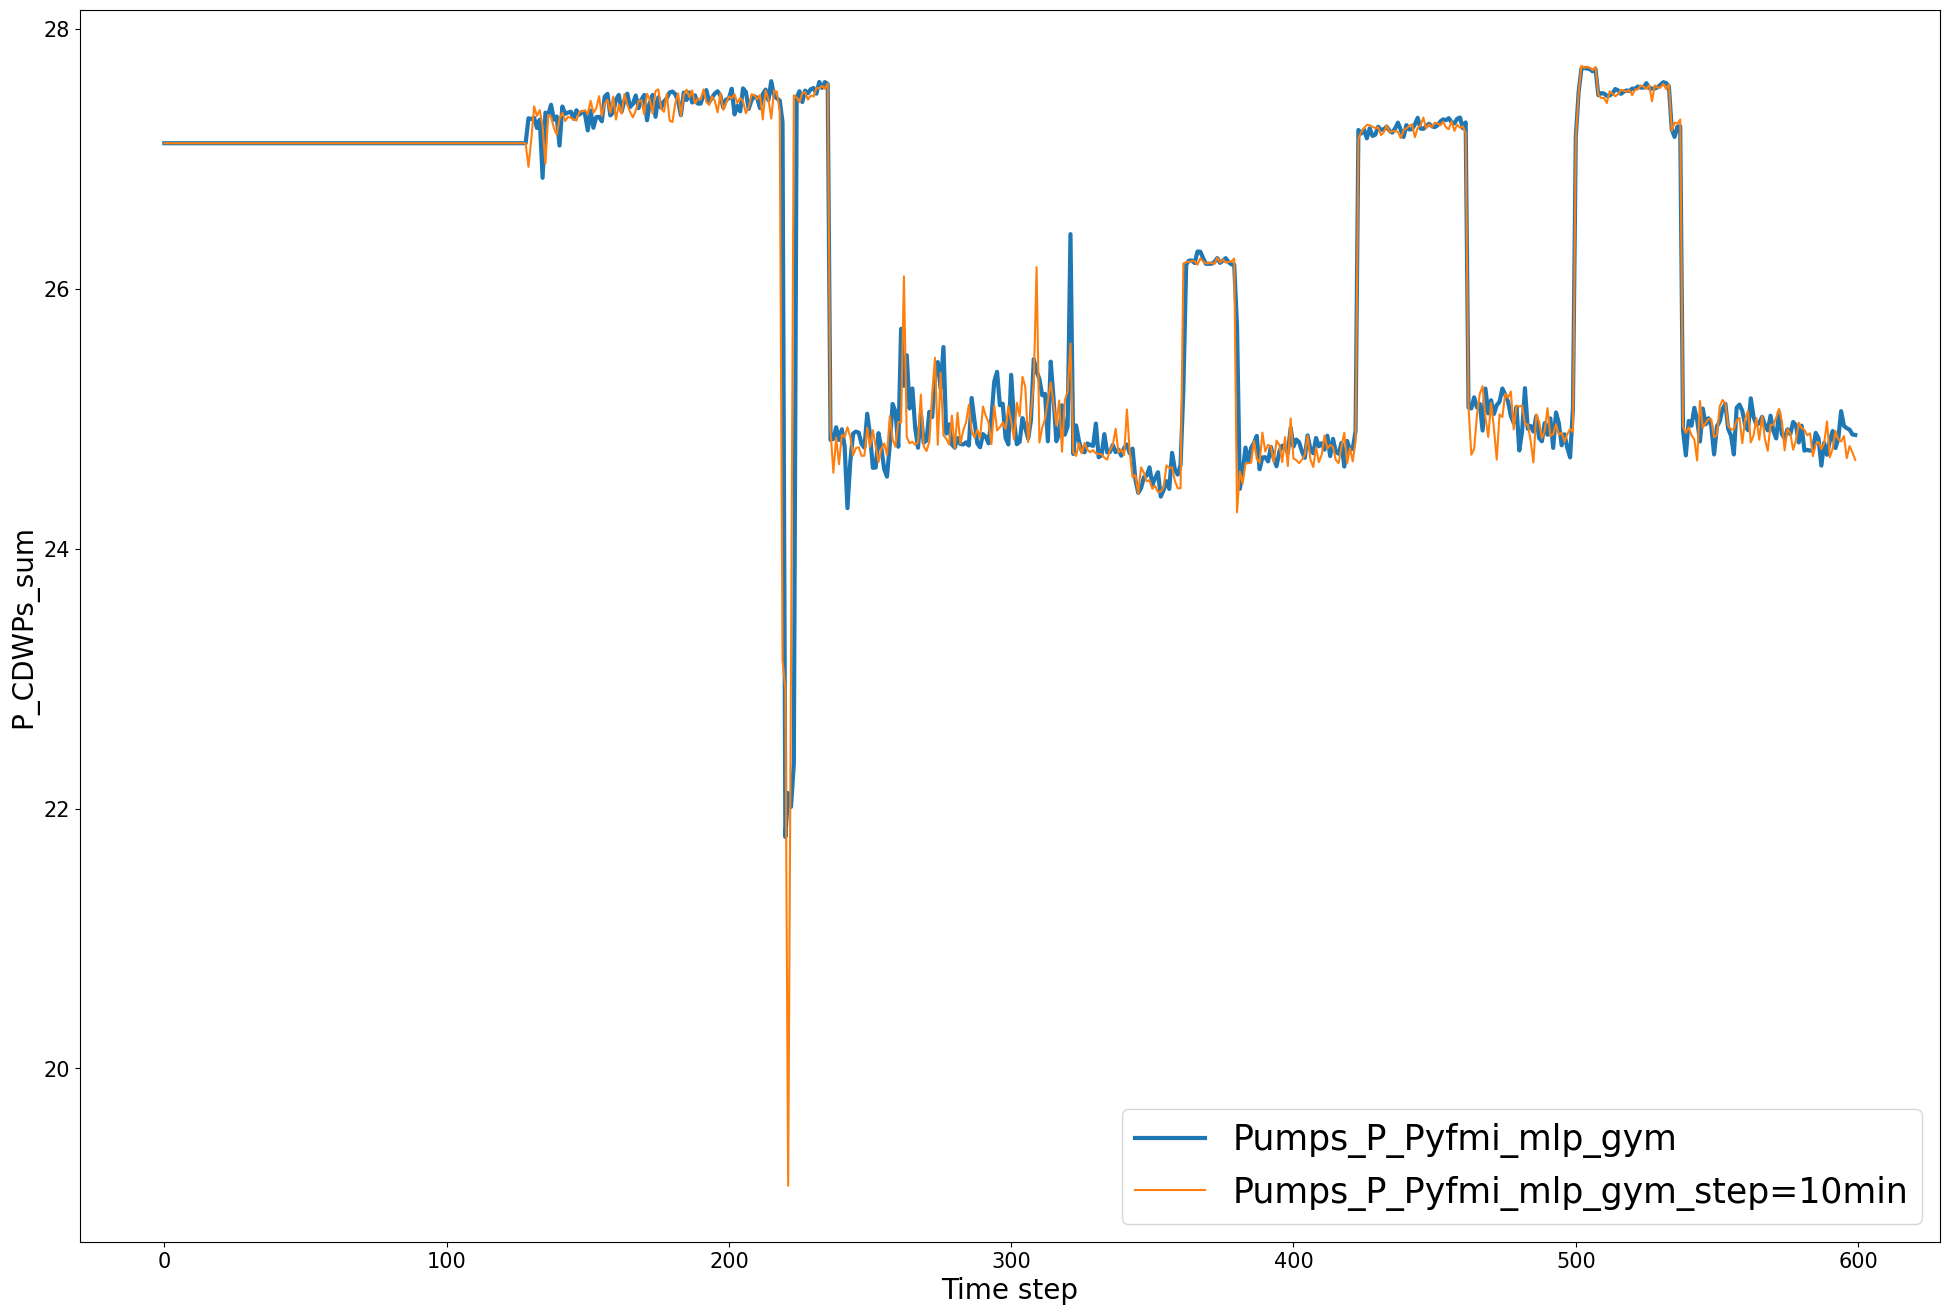

In [89]:
df_pyfmi_mlp_gym = pd.read_csv('Pumps_P_Pyfmi_mlp_gym.csv')

subset = df_pyfmi_mlp_gym['P_CDWPs_sum']
filtered_indices = subset.reset_index().index % 2 == 0
filtered_rows = subset[filtered_indices]
Pumps_P_Pyfmi_mlp_gym_10min_step = pd.read_csv('Pumps_P_Pyfmi_mlp_gym_step=10min.csv')
plt.figure(figsize=(24, 16))

plt.plot(range(0, 600), filtered_rows[0:600] / 1000,'-', label='Pumps_P_Pyfmi_mlp_gym',  lw=3)
plt.plot(range(0, 600), Pumps_P_Pyfmi_mlp_gym_10min_step['P_CDWPs_sum'].iloc[0:600] / 1000,'-', label='Pumps_P_Pyfmi_mlp_gym_step=10min')
plt.legend(fontsize=25)
# plt.title('Simulink vs. Pyfmi P_CDWPs_sum Comparative Analysis',fontsize=30)
plt.xlabel('Time step', fontsize=20)
plt.ylabel('P_CDWPs_sum', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()